# Conditional Random Fields (CRF)

* **Named Entity Recognition (NER)** is the process of recognizing information units like **names**, including person, organization and location names, and **numeric expressions** including time, date, money and percent expressions from **unstructured text**.

    * Who is the director of **Batman 1989**?


* NER is usually converted to the problem of **tagging** each word in the given text. 

    * For example, the tagging of the question **Who is the director of Batman 1989?** could be:
        
        | Id | Word | Tag | Description |
        | ---- | ---- | ---- | ---- |
        | 0 | Who | O | others |
        | 1 | is | O | - |
        | 2 | the | O | - |
        | 3 | director | O | - |
        | 4 | of | O | - |
        | 5 | Batman | **B-mov** | mov = movie |
        | 6 | 1989 | **I-mov** | - |
        | 7 | ? | O | - |

    * The above tages follow the [**Inside–outside–beginning (IOB) format**](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)#cite_note-2): 
    
        * An O tag indicates that a token belongs to **no chunk**. In NER, it means the word is not an entity.
        
        * The B- prefix before a tag indicates that the tag is the **beginning** of a chunk.
        
        * The I- prefix before a tag indicates that the tag is **inside** a chunk.

## Install required packages

In [1]:
! pip install sklearn_crfsuite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 965 kB 13.4 MB/s 


In [2]:
! python -m nltk.downloader averaged_perceptron_tagger

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [65]:
# import required packages
import pandas as pd
import numpy as np

import sklearn_crfsuite

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
from itertools import chain
import sklearn
import seaborn as sn
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

from collections import Counter

In [5]:
# ONLY FOR GOOGLE COLAB
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os

In [8]:
# ONLY FOR GOOGLE COLAB
os.chdir('drive/MyDrive/UZH/1. ATAI/Project')

In [11]:
os.chdir('data/MIT_corpus')

In [12]:
!ls

cache_dir		 MIT_full_train_cased.csv  MIT_trivia_test.txt
MIT_corpus_train.csv	 MIT_full_train.csv	   MIT_trivia_train.txt
MIT_full_test_cased.csv  MIT_full_train.txt	   mycrf.pickle
MIT_full_test.csv	 MIT_movies_test.txt	   outputs
MIT_full_test.txt	 MIT_movies_train.txt	   runs


## Test small dataset

In [17]:
# Read data
with open('MIT_movies_train.txt','r') as file:
    df_list = file.readlines()
df_list[:20]

['O\twhat\n',
 'O\tmovies\n',
 'O\tstar\n',
 'B-ACTOR\tbruce\n',
 'I-ACTOR\twillis\n',
 '\n',
 'O\tshow\n',
 'O\tme\n',
 'O\tfilms\n',
 'O\twith\n',
 'B-ACTOR\tdrew\n',
 'I-ACTOR\tbarrymore\n',
 'O\tfrom\n',
 'O\tthe\n',
 'B-YEAR\t1980s\n',
 '\n',
 'O\twhat\n',
 'O\tmovies\n',
 'O\tstarred\n',
 'O\tboth\n']

In [18]:
# Add a sentence id
sentence_id = 0
df_list_new = []
for line in df_list:
  if line == '\n':
    sentence_id += 1
  else:
    df_list_new.append(str(sentence_id) + '\t' + line)
df_list_new[:20]

['0\tO\twhat\n',
 '0\tO\tmovies\n',
 '0\tO\tstar\n',
 '0\tB-ACTOR\tbruce\n',
 '0\tI-ACTOR\twillis\n',
 '1\tO\tshow\n',
 '1\tO\tme\n',
 '1\tO\tfilms\n',
 '1\tO\twith\n',
 '1\tB-ACTOR\tdrew\n',
 '1\tI-ACTOR\tbarrymore\n',
 '1\tO\tfrom\n',
 '1\tO\tthe\n',
 '1\tB-YEAR\t1980s\n',
 '2\tO\twhat\n',
 '2\tO\tmovies\n',
 '2\tO\tstarred\n',
 '2\tO\tboth\n',
 '2\tB-ACTOR\tal\n',
 '2\tI-ACTOR\tpacino\n']

In [29]:
with open('MIT_corpus_test.csv', 'w') as MIT_corpus:
  MIT_corpus.writelines(df_list_new)

In [30]:
MIT_df = pd.read_csv('MIT_corpus_test.csv',sep='\t',names=['sentence_id','tags','words'])[['sentence_id','words','tags']]
MIT_df

,sentence_id,words,tags
0,0,are,O
1,0,there,O
2,0,any,O
3,0,good,O
4,0,romantic,B-GENRE
...,...,...,...
24681,2442,movie,O
24682,2442,about,O
24683,2442,captain,B-CHARACTER
24684,2442,jack,I-CHARACTER


In [31]:
words = MIT_df['words'].to_list()
words[:10]

['are',
 'there',
 'any',
 'good',
 'romantic',
 'comedies',
 'out',
 'right',
 'now',
 'show']

In [32]:
pos_tags = pos_tag(words) 

In [33]:
tags = []
for word, tag in pos_tags:
  tags.append(tag)

In [34]:
MIT_df['pos'] = tags

In [35]:
MIT_df

,sentence_id,words,tags,pos
0,0,are,O,VBP
1,0,there,O,RB
2,0,any,O,DT
3,0,good,O,JJ
4,0,romantic,B-GENRE,JJ
...,...,...,...,...
24681,2442,movie,O,NN
24682,2442,about,O,IN
24683,2442,captain,B-CHARACTER,NN
24684,2442,jack,I-CHARACTER,NN


In [36]:
MIT_df.to_csv('MIT_corpus_test.csv')

In [153]:
! pip install titlecase

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for titlecase: filename=titlecase-2.4-py2.py3-none-any.whl size=10954 sha256=012d15af775a393f93e6e298925d2d5336a35dd9d675ab2ee23badd17e704099
  Stored in directory: /root/.cache/pip/wheels/91/a2/77/0f38a909699235377b1163853a43b1ac1a6c842905c4197367
Successfully built titlecase


In [155]:
from titlecase import titlecase

In [156]:
titlecase("this is jack sparrow and he is an actor")

'This Is Jack Sparrow and He Is an Actor'

## CRF

In [201]:
## load train and test set
train_df = pd.read_csv('MIT_corpus_train.csv')
test_df = pd.read_csv('MIT_corpus_test.csv')

In [202]:
train_df

,Unnamed: 0,sentence_id,words,tags,pos
0,0,0,what,O,WP
1,1,0,movies,O,NNS
2,2,0,star,O,VBP
3,3,0,bruce,B-ACTOR,NN
4,4,0,willis,I-ACTOR,NN
...,...,...,...,...,...
99486,99486,9774,scarlett,B-CHARACTER,JJ
99487,99487,9774,o,I-CHARACTER,NN
99488,99488,9774,hara,I-CHARACTER,NN
99489,99489,9774,in,O,IN


In [159]:
test_df

,Unnamed: 0,sentence_id,words,tags,pos
0,0,0,are,O,VBP
1,1,0,there,O,RB
2,2,0,any,O,DT
3,3,0,good,O,JJ
4,4,0,romantic,B-GENRE,JJ
...,...,...,...,...,...
24681,24681,2442,movie,O,NN
24682,24682,2442,about,O,IN
24683,24683,2442,captain,B-CHARACTER,NN
24684,24684,2442,jack,I-CHARACTER,NN


In [183]:
for i in range(len(train_df)):
  if i == 0 or train_df['sentence_id'][i] > train_df['sentence_id'][i-1]:
    train_df['words'][i] = train_df['words'][i].title()

# transform first character of lower case word to upper case based on tags
for i in range(len(test_df)):
    if train_df['tags'][i] in ['B-ACTOR', 'I-ACTOR', 'B-Actor', 'I-Actor', 'B-Character_Name', 'I-Character_Name', 'B-Character', 'I-Character', 'B-CHARACTER', 'I-CHARACTER', 'B-Director', 'I-Director', 'B-DIRECTOR', 'I-DIRECTOR', 'B-Award', 'I-Award']:
        train_df['words'][i] = str(train_df['words'][i]).title()

# transform first character of lower case word to upper case based on tags
title = ''
cased_title = ''
len_title = 0
for i in range(len(train_df)):
  if train_df['tags'][i] in ['B-TITLE', 'I-TITLE']:
    title = title + " " + str(train_df['words'][i])
    len_title += 1
  else:
    cased_title = titlecase(str(title))
    tokens = word_tokenize(cased_title)
    for t in range(len(tokens), 0, -1):
      train_df['words'][i - t] = tokens[len(tokens) - t]
    title = ''
    cased_title = ''
    len_title = 0

train_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Unnamed: 0,sentence_id,words,tags,pos
0,0,0,What,O,WP
1,1,0,movies,O,NNS
2,2,0,star,O,VBP
3,3,0,Bruce,B-ACTOR,NN
4,4,0,Willis,I-ACTOR,NN
...,...,...,...,...,...
99486,99486,9774,scarlett,B-CHARACTER,JJ
99487,99487,9774,o,I-CHARACTER,NN
99488,99488,9774,hara,I-CHARACTER,NN
99489,99489,9774,in,O,IN


In [184]:
for i in range(len(test_df)):
  if i == 0 or test_df['sentence_id'][i] > test_df['sentence_id'][i-1]:
    test_df['words'][i] = test_df['words'][i].title()

# transform first character of lower case word to upper case based on tags
for i in range(len(test_df)):
  if test_df['tags'][i] in ['B-ACTOR', 'I-ACTOR', 'B-Actor', 'I-Actor', 'B-Character_Name', 'I-Character_Name', 'B-Character', 'I-Character', 'B-Director', 'I-Director', 'B-DIRECTOR', 'I-DIRECTOR', 'B-Award', 'I-Award']:
      test_df['words'][i] = str(test_df['words'][i]).title()

# transform first character of lower case word to upper case based on tags
title = ''
cased_title = ''
len_title = 0
for i in range(len(test_df)):
  if test_df['tags'][i] in ['B-TITLE', 'I-TITLE']:
    title = title + " " + str(test_df['words'][i])
    len_title += 1
  else:
    cased_title = titlecase(str(title))
    tokens = word_tokenize(cased_title)
    for t in range(len(tokens), 0, -1):
      test_df['words'][i - t] = tokens[len(tokens) - t]
    title = ''
    cased_title = ''
    len_title = 0

test_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Unnamed: 0,sentence_id,words,tags,pos
0,0,0,Are,O,VBP
1,1,0,there,O,RB
2,2,0,any,O,DT
3,3,0,good,O,JJ
4,4,0,romantic,B-GENRE,JJ
...,...,...,...,...,...
24681,24681,2442,movie,O,NN
24682,24682,2442,about,O,IN
24683,24683,2442,captain,B-CHARACTER,NN
24684,24684,2442,jack,I-CHARACTER,NN


In [185]:
train_df.to_csv('MIT_corpus_train_cased.csv')
test_df.to_csv('MIT_corpus_test_cased.csv')

In [203]:
def collate(dataframe):
    agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['words'].values.tolist(), s['pos'].values.tolist(), s['tags'].values.tolist())]
    grouped = dataframe.groupby('sentence_id').apply(agg_func)
    return list(grouped)

print("--- original train dataframe:\n")
print(train_df)
train_sentences = collate(train_df)
print("\n--- number of sentences: {}\n".format(len(train_sentences)))
print(train_sentences[0:2])

print("\n\n--- original test dataframe:\n")
print(test_df)
test_sentences = collate(test_df)
print("\n--- number of sentences: {}\n".format(len(test_sentences)))
print(test_sentences[0:2])

--- original train dataframe:

       Unnamed: 0  sentence_id     words         tags  pos
0               0            0      what            O   WP
1               1            0    movies            O  NNS
2               2            0      star            O  VBP
3               3            0     bruce      B-ACTOR   NN
4               4            0    willis      I-ACTOR   NN
...           ...          ...       ...          ...  ...
99486       99486         9774  scarlett  B-CHARACTER   JJ
99487       99487         9774         o  I-CHARACTER   NN
99488       99488         9774      hara  I-CHARACTER   NN
99489       99489         9774        in            O   IN
99490       99490         9774        it            O  PRP

[99491 rows x 5 columns]

--- number of sentences: 9775

[[('what', 'WP', 'O'), ('movies', 'NNS', 'O'), ('star', 'VBP', 'O'), ('bruce', 'NN', 'B-ACTOR'), ('willis', 'NN', 'I-ACTOR')], [('show', 'VB', 'O'), ('me', 'PRP', 'O'), ('films', 'NNS', 'O'), ('with', 'I

In [204]:
print('- number of training sentences: ', len(train_sentences))
print('- number of testing sentences: ', len(test_sentences))
print(train_sentences[0])
print(test_sentences[0])

- number of training sentences:  9775
- number of testing sentences:  2443
[('what', 'WP', 'O'), ('movies', 'NNS', 'O'), ('star', 'VBP', 'O'), ('bruce', 'NN', 'B-ACTOR'), ('willis', 'NN', 'I-ACTOR')]
[('are', 'VBP', 'O'), ('there', 'RB', 'O'), ('any', 'DT', 'O'), ('good', 'JJ', 'O'), ('romantic', 'JJ', 'B-GENRE'), ('comedies', 'NNS', 'I-GENRE'), ('out', 'RP', 'O'), ('right', 'RB', 'B-YEAR'), ('now', 'RB', 'I-YEAR')]


* Next, we extract more features (word parts, IBO prefixes, lower/title/upper flags, features of neighboring words) and convert them to the data structure required by sklearn-crfsuite — each sentence should be converted to a list of dicts.

In [205]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        #'word.isupper()': word.isupper(),
        #'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            #'+1:word.istitle()': word1.istitle(),
            #'+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features

#-----------------------------------------------------------------------
def word2features2(sent, i):
    word = str(sent[i][0])
    postag = str(sent[i][1])
    
    features = {
        'bias': 1.0, # check for bias
        'word.lower()': word.lower(),  # the word in lowercase
        'len(word)': len(word), # length of the word
        'word[:3]': word[:3],    # first three characters
        'word[:2]': word[:2],    # first two characters
        'word[-3:]': word[-3:],  # last three characters
        'word[-2:]': word[-2:],  # last two characters
        'word': word, # the input word as it is
        'word.isupper()': word.isupper(),  # true, if the word is in uppercase
        'word.istitle()': word.istitle(),  # true, if the first character is in uppercase and remaining characters are in lowercase
        'word.isdigit()': word.isdigit(),  # true, if all characters are digits
        'postag': postag,  # POS tag
        'postag[:2]': postag[:2],  # IOB prefix
    }
    if i > 0:
        word1 = str(sent[i-1][0])  # the previous word
        postag1 = str(sent[i-1][1])  # POS tag of the previous word
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:len(word)': len(word1),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:word[:3]': word1[:3],
            '-1:word[:2]': word1[:2],
            '-1:word[-3:]': word1[-3:],
            '-1:word[-2:]': word1[-2:],
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })  # add some features of the previous word
    else:
        features['BOS'] = True  # BOS: begining of the sentence
        
    if i < len(sent)-1:
        word1 = str(sent[i+1][0])  # the next word
        postag1 = str(sent[i+1][1])  # POS tag of the next word
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word': word1,
            '+1:len(word)': len(word1),
            '+1:word[:3]': word1[:3],
            '+1:word[:2]': word1[:2],
            '+1:word[-3:]': word1[-3:],
            '+1:word[-2:]': word1[-2:],
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })  # add some features of the next word
    else:
        features['EOS'] = True  # EOS: end of the sentence
    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [206]:
# X and y in the required format
X_train, y_train = [sent2features(s) for s in train_sentences], [sent2labels(s) for s in train_sentences]
X_test, y_test = [sent2features(s) for s in test_sentences], [sent2labels(s) for s in test_sentences]

# unique tags for reporting classification results
classes = np.unique(MIT_df.tags.values)
classes = classes.tolist()

new_classes = classes.copy()
new_classes.pop()

'O'

In [ ]:
!pip install -U 'scikit-learn<0.24'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.8 MB 7.9 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.23.2 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.2 which is incompatible.


In [55]:
labels = list(crf.classes_)
labels.remove('O')
labels

['B-ACTOR',
 'I-ACTOR',
 'B-YEAR',
 'B-TITLE',
 'B-GENRE',
 'I-GENRE',
 'B-DIRECTOR',
 'I-DIRECTOR',
 'B-SONG',
 'I-SONG',
 'B-PLOT',
 'I-PLOT',
 'B-REVIEW',
 'B-CHARACTER',
 'I-CHARACTER',
 'B-RATING',
 'B-RATINGS_AVERAGE',
 'I-RATINGS_AVERAGE',
 'I-TITLE',
 'I-RATING',
 'B-TRAILER',
 'I-TRAILER',
 'I-REVIEW',
 'I-YEAR']

In [61]:
! pip install sklearn.grid_search

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement sklearn.grid_search (from versions: none)
ERROR: No matching distribution found for sklearn.grid_search


In [207]:
# train CRF model
# Gradient descent using the L-BFGS method
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=10, c2=0.1, 
    max_iterations=100,
    all_possible_transitions=False
)

from sklearn.model_selection import cross_val_predict
# This might take a while (about 3 minutes). If you want to speed up the training, you can reduce the number of training samples.
pred = cross_val_predict(estimator=crf, X=X_train, y=y_train, cv=5)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [208]:
report = metrics.flat_classification_report(y_pred=pred, y_true=y_train)
print(report)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

          B-ACTOR       0.73      0.86      0.79      3220
      B-CHARACTER       0.77      0.09      0.16       385
       B-DIRECTOR       0.90      0.68      0.77      1720
          B-GENRE       0.90      0.87      0.89      4354
           B-PLOT       0.59      0.43      0.50      1927
         B-RATING       0.98      0.96      0.97      2007
B-RATINGS_AVERAGE       0.89      0.79      0.84      1869
         B-REVIEW       0.00      0.00      0.00       221
           B-SONG       0.72      0.35      0.47       245
          B-TITLE       0.58      0.51      0.55      2376
        B-TRAILER       0.75      0.42      0.54       113
           B-YEAR       0.94      0.94      0.94      2858
          I-ACTOR       0.72      0.85      0.78      3474
      I-CHARACTER       0.86      0.09      0.16       342
       I-DIRECTOR       0.90      0.68      0.77      1850
          I-GENRE       0.82      0.72      0.77       

In [209]:
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_transitions=False, c1=10, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

In [104]:
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)



Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 59.5min finished


RandomizedSearchCV(cv=3,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None, max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdca46e18d0>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdca46e1050>},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['B-ACTOR', 'I-ACTOR', 'B-YEAR', 'B-TITLE', 'B-GENRE', 'I-GENRE', 'B-DIRECTOR', 'I-DIRECTOR', 'B-SONG', 'I-SONG', 'B-PLOT', 'I-PLOT', 'B-REVIEW', 'B-CHARACTER', 'I-CHARACTER', 'B-RATING', 'B-RATINGS_AVERAGE', 'I-RATINGS_AVERAGE', 'I-TITLE', 'I-RATING', 'B-TRAILER', 'I-TRAILER', 'I-REVIEW', 'I-YEAR']),
                   verbose=1)

In [105]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.22624756241469188, 'c2': 0.012029520802405545}
best CV score: 0.796253315679969
model size: 1.00M


In [120]:
y_pred = crf.predict(X_test)

print("--- performance of the CRF model")
print(metrics.flat_classification_report(y_test, y_pred))

--- performance of the CRF model


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


                   precision    recall  f1-score   support

          B-ACTOR       0.89      0.92      0.91       812
      B-CHARACTER       0.66      0.52      0.58        90
       B-DIRECTOR       0.89      0.84      0.87       456
          B-GENRE       0.93      0.96      0.94      1117
           B-PLOT       0.69      0.64      0.67       491
         B-RATING       0.98      0.97      0.97       500
B-RATINGS_AVERAGE       0.92      0.87      0.90       451
         B-REVIEW       0.37      0.20      0.26        56
           B-SONG       0.72      0.57      0.64        54
          B-TITLE       0.75      0.76      0.76       562
        B-TRAILER       0.80      0.80      0.80        30
           B-YEAR       0.95      0.94      0.94       720
          I-ACTOR       0.88      0.91      0.89       862
      I-CHARACTER       0.51      0.40      0.45        75
       I-DIRECTOR       0.87      0.84      0.86       496
          I-GENRE       0.84      0.70      0.76       

In [121]:
with open('rs.pickle', 'wb') as f:
  pickle.dump(rs, f)

Dark blue => 0.7773, dark red => 0.7963


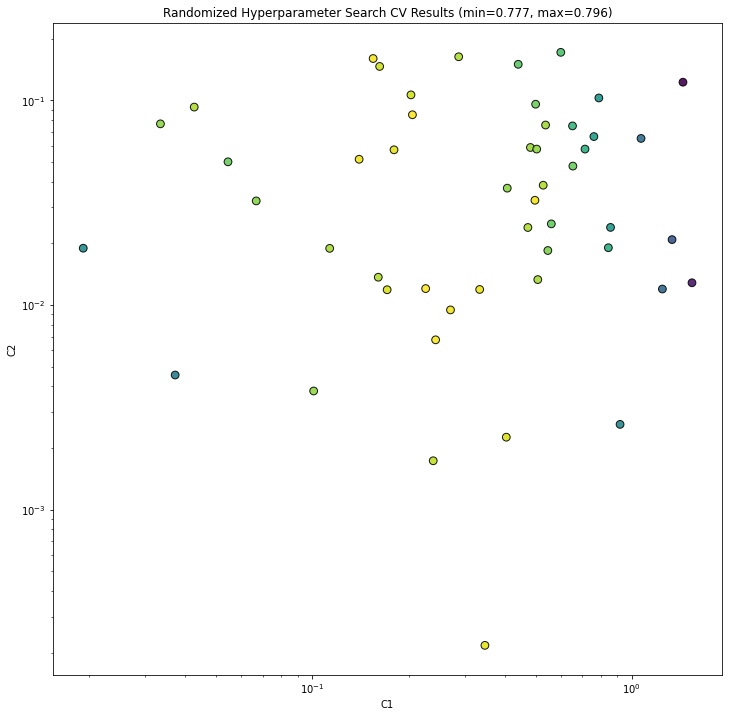

In [107]:
_x = rs.cv_results_['param_c1']
_y = rs.cv_results_['param_c2']
_c = rs.cv_results_['mean_test_score']

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))



              precision    recall  f1-score   support

           B       0.92      0.86      0.89      5339
           I       0.87      0.85      0.86      4418
           O       0.93      0.96      0.95     14929

    accuracy                           0.92     24686
   macro avg       0.91      0.89      0.90     24686
weighted avg       0.92      0.92      0.92     24686

Accuracy: 0.9185368224904804 for ['B' 'I' 'O']
                   precision    recall  f1-score   support

          B-ACTOR       0.77      0.89      0.82       812
      B-CHARACTER       0.76      0.24      0.37        90
       B-DIRECTOR       0.93      0.70      0.80       456
          B-GENRE       0.91      0.90      0.90      1117
           B-PLOT       0.60      0.44      0.50       491
         B-RATING       0.98      0.97      0.97       500
B-RATINGS_AVERAGE       0.91      0.83      0.87       451
         B-REVIEW       0.67      0.04      0.07        56
           B-SONG       0.90      0.50  

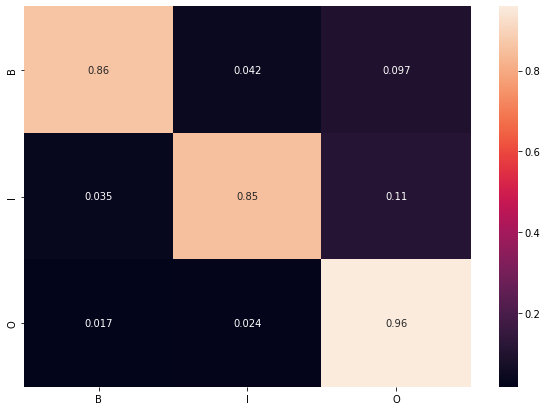

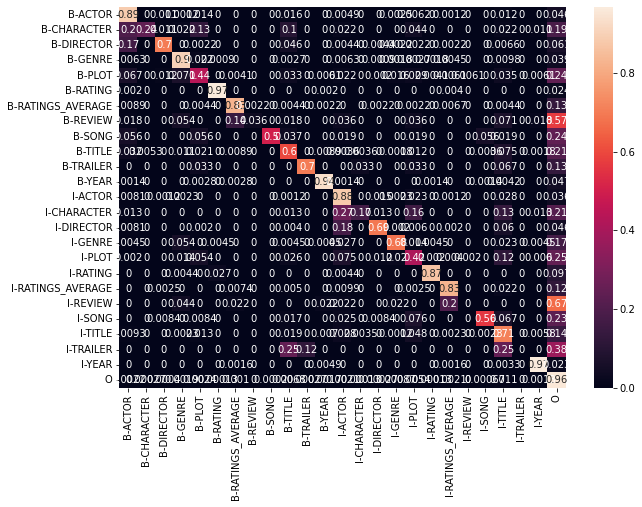

In [214]:
def confusion_matrix(y_true, y_pred, summarize_iob_tags=False):
    f_y_test = list(chain.from_iterable(y_test))
    f_y_pred = list(chain.from_iterable(y_pred))
    if summarize_iob_tags:
        # summarize IOB tags to only keep the first letter (eg. B-art -> B)
        f_y_test = [t[0] for t in f_y_test]
        f_y_pred = [t[0] for t in f_y_pred]

    labels = np.unique(f_y_test)
    print(sklearn.metrics.classification_report(f_y_test, f_y_pred))
    print(f"Accuracy: {sklearn.metrics.accuracy_score(f_y_test, f_y_pred)} for {labels}")

    cm = sklearn.metrics.confusion_matrix(f_y_test, f_y_pred, labels=labels)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index = labels, columns = labels).fillna(0)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)

y_pred = crf.predict(X_test)

confusion_matrix(y_test, y_pred, summarize_iob_tags=True)
confusion_matrix(y_test, y_pred, summarize_iob_tags=False)

In [113]:
# group B and I results
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)

In [114]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['B-ACTOR', 'I-ACTOR', 'B-CHARACTER', 'I-CHARACTER', 'B-DIRECTOR', 'I-DIRECTOR', 'B-GENRE', 'I-GENRE', 'B-PLOT', 'I-PLOT', 'B-RATING', 'I-RATING', 'B-RATINGS_AVERAGE', 'I-RATINGS_AVERAGE', 'B-REVIEW', 'I-REVIEW', 'B-SONG', 'I-SONG', 'B-TITLE', 'I-TITLE', 'B-TRAILER', 'I-TRAILER', 'B-YEAR', 'I-YEAR'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

          B-ACTOR      0.893     0.917     0.905       812
          I-ACTOR      0.879     0.911     0.895       862
      B-CHARACTER      0.662     0.522     0.584        90
      I-CHARACTER      0.508     0.400     0.448        75
       B-DIRECTOR      0.887     0.844     0.865       456
       I-DIRECTOR      0.873     0.845     0.859       496
          B-GENRE      0.927     0.955     0.941      1117
          I-GENRE      0.839     0.703     0.765       222
           B-PLOT      0.691     0.642     0.665       491
           I-PLOT      0.636     0.508     0.565       496
         B-RATING      0.976     0.968     0.972       500
         I-RATING      0.971     0.881     0.923       226
B-RATINGS_AVERAGE      0.923     0.874     0.897       451
I-RATINGS_AVERAGE      0.884     0.871     0.877       403
         B-REVIEW      0.367     0.196     0.256        56
         I-REVIEW      0.333     0.156     0.212       

In [115]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
B-DIRECTOR -> I-DIRECTOR 7.993978
B-TRAILER -> I-TRAILER 7.868031
B-ACTOR -> I-ACTOR 7.655800
B-SONG -> I-SONG  6.982533
I-YEAR -> I-YEAR  6.729962
B-TITLE -> I-TITLE 6.573529
B-CHARACTER -> I-CHARACTER 6.531866
I-GENRE -> I-GENRE 6.466090
I-SONG -> I-SONG  6.454556
I-REVIEW -> I-REVIEW 6.397908
I-CHARACTER -> I-CHARACTER 6.261068
B-REVIEW -> I-REVIEW 6.257025
I-RATING -> I-RATING 6.131716
B-PLOT -> I-PLOT  6.065158
I-TITLE -> I-TITLE 5.996836
I-PLOT -> I-PLOT  5.949031
B-GENRE -> I-GENRE 5.833426
B-RATING -> I-RATING 5.406812
B-RATINGS_AVERAGE -> I-RATINGS_AVERAGE 5.310291
I-DIRECTOR -> I-DIRECTOR 5.278009

Top unlikely transitions:
B-YEAR -> I-TITLE -3.337573
B-PLOT -> B-PLOT  -3.369253
B-RATINGS_AVERAGE -> B-RATINGS_AVERAGE -3.395941
B-DIRECTOR -> B-DIRECTOR -3.495333
I-SONG -> B-SONG  -3.691681
B-ACTOR -> B-ACTOR -4.232656
B-RATING -> B-RATING -4.441393
B-YEAR -> B-YEAR  -4.481146
O      -> I-RATING -4.856468
O      -> I-DIRECTOR -5.362050
O      -> I-GENRE 

In [116]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
10.562892 B-RATING word.lower():unrated
10.280579 B-TITLE  word.lower():inception
9.904793 B-SONG   -1:word.lower():song
9.685611 B-RATINGS_AVERAGE word.lower():watchable
8.666226 B-GENRE  word.lower():action
8.618979 B-GENRE  word.lower():thriller
8.601309 O        word.lower():ever
8.377265 B-GENRE  word.lower():laugh
8.275700 B-DIRECTOR -1:word.lower():director
8.193771 B-GENRE  -1:word.lower():fun
7.923112 I-DIRECTOR +1:word.lower():landis
7.834985 B-REVIEW -1:word.lower():rich
7.717588 B-GENRE  word.lower():animated
7.481300 B-RATINGS_AVERAGE word.lower():decent
7.345871 B-TRAILER word.lower():trailer
7.327543 B-PLOT   +1:word.lower():noir
7.239306 B-ACTOR  word.lower():quaids
7.235430 B-GENRE  word.lower():thrillers
7.182843 B-GENRE  word.lower():adventure
6.851141 B-ACTOR  word.lower():carradines
6.814503 O        word.lower():list
6.729254 B-RATINGS_AVERAGE word.lower():mediocre
6.689115 B-REVIEW -1:word.lower():vow
6.631367 B-GENRE  word.lower():animation
6.59867

### ELI5

In [47]:
! pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 14.8 MB/s 
     |████████████████████████████████| 133 kB 56.8 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=c434f8dad596e3a5ee9a65f1566fa6dbdafd4ed8c4d9fee1ca2c608095f14101
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 5.7.16 requires jinja2<=3.0.0, but you have jinja2 3.1.2 which is incompatible.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incomp

In [48]:
import eli5

In [211]:
# insprect model weights and learned features
eli5.show_weights(crf, top=10)  # top: number of features to show

From \ To,O,B-ACTOR,I-ACTOR,B-CHARACTER,I-CHARACTER,B-DIRECTOR,I-DIRECTOR,B-GENRE,I-GENRE,B-PLOT,I-PLOT,B-RATING,I-RATING,B-RATINGS_AVERAGE,I-RATINGS_AVERAGE,B-REVIEW,I-REVIEW,B-SONG,I-SONG,B-TITLE,I-TITLE,B-TRAILER,I-TRAILER,B-YEAR,I-YEAR
O,2.757,2.529,0.0,2.69,0.0,2.48,0.0,2.049,0.0,2.283,0.0,2.108,0.0,2.757,0.0,2.104,0.0,2.096,0.0,2.857,0.0,1.278,0.0,2.069,0.0
B-ACTOR,0.0,0.0,9.133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I-ACTOR,0.62,-0.001,5.071,0.0,0.0,0.0,0.0,0.899,0.0,0.687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B-CHARACTER,0.0,0.0,0.0,0.0,7.252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I-CHARACTER,0.0,0.0,0.0,0.0,5.895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B-DIRECTOR,-0.161,0.0,0.0,0.0,0.0,0.0,8.492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.647,0.0,0.0,0.0,0.0,0.0
I-DIRECTOR,0.393,0.0,0.0,0.0,0.0,0.0,4.569,0.931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B-GENRE,1.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.175,1.215,0.0,0.638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I-GENRE,0.615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B-PLOT,0.661,0.0,0.0,0.0,0.0,0.0,0.0,0.481,0.0,0.0,8.144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [197]:
eli5.show_weights(crf, top=10, targets=['O', 'B-ACTOR', 'I-ACTOR'])

In [198]:
eli5.show_weights(crf, top=10, feature_re='^word',
                  horizontal_layout=False, show=['targets'])

In [199]:
eli5.show_weights(crf, top=10, feature_re='^word',
                  horizontal_layout=False, show=['targets'])

In [62]:
import pickle

In [212]:
# save
with open('crf_uncased_lower.pickle', 'wb') as f:
  pickle.dump(crf, f)

In [228]:
# load
with open('crf_uncased.pickle', 'rb') as f:
  crf = pickle.load(f)

## Now, we consider the full dataset (incl. complex statements/questions)


### Dataset transformation

In [ ]:
# Read train data
with open('MIT_full_train.txt','r') as file:
    df_train = file.readlines()
df_train[:20]

['O\twhat\n',
 'O\tmovies\n',
 'O\tstar\n',
 'B-ACTOR\tbruce\n',
 'I-ACTOR\twillis\n',
 '\n',
 'O\tshow\n',
 'O\tme\n',
 'O\tfilms\n',
 'O\twith\n',
 'B-ACTOR\tdrew\n',
 'I-ACTOR\tbarrymore\n',
 'O\tfrom\n',
 'O\tthe\n',
 'B-YEAR\t1980s\n',
 '\n',
 'O\twhat\n',
 'O\tmovies\n',
 'O\tstarred\n',
 'O\tboth\n']

In [ ]:
# Read test data
with open('MIT_full_test.txt','r') as file:
    df_test = file.readlines()
df_test[:20]

['O\tare\n',
 'O\tthere\n',
 'O\tany\n',
 'O\tgood\n',
 'B-GENRE\tromantic\n',
 'I-GENRE\tcomedies\n',
 'O\tout\n',
 'B-YEAR\tright\n',
 'I-YEAR\tnow\n',
 '\n',
 'O\tshow\n',
 'O\tme\n',
 'O\ta\n',
 'O\tmovie\n',
 'O\tabout\n',
 'B-PLOT\tcars\n',
 'I-PLOT\tthat\n',
 'I-PLOT\ttalk\n',
 '\n',
 'O\tlist\n']

In [ ]:
# Add a sentence id
sentence_id = 0
df_train_new = []
for line in df_train:
  if line == '\n':
    sentence_id += 1
  else:
    df_train_new.append(str(sentence_id) + '\t' + line)
df_train_new[:20]

['0\tO\twhat\n',
 '0\tO\tmovies\n',
 '0\tO\tstar\n',
 '0\tB-ACTOR\tbruce\n',
 '0\tI-ACTOR\twillis\n',
 '1\tO\tshow\n',
 '1\tO\tme\n',
 '1\tO\tfilms\n',
 '1\tO\twith\n',
 '1\tB-ACTOR\tdrew\n',
 '1\tI-ACTOR\tbarrymore\n',
 '1\tO\tfrom\n',
 '1\tO\tthe\n',
 '1\tB-YEAR\t1980s\n',
 '2\tO\twhat\n',
 '2\tO\tmovies\n',
 '2\tO\tstarred\n',
 '2\tO\tboth\n',
 '2\tB-ACTOR\tal\n',
 '2\tI-ACTOR\tpacino\n']

In [ ]:
# Add a sentence id
sentence_id = 0
df_test_new = []
for line in df_test:
  if line == '\n':
    sentence_id += 1
  else:
    df_test_new.append(str(sentence_id) + '\t' + line)
df_test_new[:20]

['0\tO\tare\n',
 '0\tO\tthere\n',
 '0\tO\tany\n',
 '0\tO\tgood\n',
 '0\tB-GENRE\tromantic\n',
 '0\tI-GENRE\tcomedies\n',
 '0\tO\tout\n',
 '0\tB-YEAR\tright\n',
 '0\tI-YEAR\tnow\n',
 '1\tO\tshow\n',
 '1\tO\tme\n',
 '1\tO\ta\n',
 '1\tO\tmovie\n',
 '1\tO\tabout\n',
 '1\tB-PLOT\tcars\n',
 '1\tI-PLOT\tthat\n',
 '1\tI-PLOT\ttalk\n',
 '2\tO\tlist\n',
 '2\tO\tthe\n',
 '2\tB-RATINGS_AVERAGE\tfive\n']

In [ ]:
with open('MIT_full_train.csv', 'w') as MIT_corpus:
  MIT_corpus.writelines(df_train_new)
with open('MIT_full_test.csv', 'w') as MIT_corpus:
  MIT_corpus.writelines(df_test_new)

### Train CRF

In [3]:
!pip install -U 'scikit-learn<0.24'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.8 MB 9.6 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.23.2 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.2 which is incompatible.


In [ ]:
! pip list

Package                       Version
----------------------------- ----------------------
absl-py                       1.3.0
aeppl                         0.0.33
aesara                        2.7.9
aiohttp                       3.8.3
aiosignal                     1.2.0
alabaster                     0.7.12
albumentations                1.2.1
altair                        4.2.0
appdirs                       1.4.4
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
async-timeout                 4.0.2
asynctest                     0.13.0
atari-py                      0.2.9
atomicwrites                  1.4.1
attrs                         22.1.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.10.3
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        5.0.1
blis                          0.7.9
bokeh

In [ ]:
MIT_train_df = pd.read_csv('MIT_full_train.csv',sep='\t',names=['sentence_id', 'tags','words'])[['sentence_id', 'words','tags']]
MIT_train_df

,sentence_id,words,tags
0,0,what,O
1,0,movies,O
2,0,star,O
3,0,bruce,B-ACTOR
4,0,willis,I-ACTOR
...,...,...,...
258309,17590,on,I-Origin
258310,17590,a,I-Origin
258311,17590,nicholas,I-Origin
258312,17590,sparks,I-Origin


In [ ]:
MIT_test_df = pd.read_csv('MIT_full_test.csv',sep='\t',names=['sentence_id', 'tags','words'])[['sentence_id', 'words','tags']]
MIT_test_df

,sentence_id,words,tags
0,0,are,O
1,0,there,O
2,0,any,O
3,0,good,O
4,0,romantic,B-GENRE
...,...,...,...
63716,4395,the,I-Origin
63717,4395,novel,I-Origin
63718,4395,by,I-Origin
63719,4395,ben,I-Origin


In [ ]:
for i in range(len(MIT_train_df)):
  if i == 0 or MIT_train_df['sentence_id'][i] > MIT_train_df['sentence_id'][i-1]:
    MIT_train_df['words'][i] = MIT_train_df['words'][i].title()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# transform first character of lower case word to upper case based on tags
for i in range(len(MIT_train_df)):
    if MIT_train_df['tags'][i] in ['B-ACTOR', 'I-ACTOR', 'B-Actor', 'I-Actor', 'B-Character_Name', 'I-Character_Name', 'B-Director', 'I-Director', 'B-DIRECTOR', 'I-DIRECTOR', 'B-TITLE', 'I-TITLE', 'B-Award', 'I-Award']:
        MIT_train_df['words'][i] = str(MIT_train_df['words'][i]).title()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


KeyboardInterrupt: ignored

In [ ]:
MIT_train_df

In [ ]:
for i in range(len(MIT_test_df)):
  if i == 0 or MIT_test_df['sentence_id'][i] > MIT_test_df['sentence_id'][i-1]:
    MIT_test_df['words'][i] = MIT_test_df['words'][i].title()

In [ ]:
# transform first character of lower case word to upper case based on tags
for i in range(len(MIT_test_df)):
    if MIT_test_df['tags'][i] in ['B-ACTOR', 'I-ACTOR', 'B-Actor', 'I-Actor', 'B-Character_Name', 'I-Character_Name', 'B-Director', 'I-Director', 'B-DIRECTOR', 'I-DIRECTOR', 'B-TITLE', 'I-TITLE', 'B-Award', 'I-Award']:
        MIT_test_df['words'][i] = str(MIT_test_df['words'][i]).title()

In [ ]:
MIT_test_df

In [ ]:
MIT_train_df.to_csv('MIT_full_train_cased.csv')
MIT_test_df.to_csv('MIT_full_test_cased.csv')

In [ ]:
tags_vals = list(set(MIT_train_df['tags'].values))
tags_vals

In [ ]:
# save cased corpora
train_words = MIT_train_df['words'].to_list()
test_words = MIT_test_df['words'].to_list()

In [ ]:
print(train_words[:10])
print(test_words[:10])

['What', 'movies', 'star', 'Bruce', 'Willis', 'Show', 'me', 'films', 'with', 'Drew']
['Are', 'there', 'any', 'good', 'romantic', 'comedies', 'out', 'right', 'now', 'Show']


In [ ]:
pos_train = pos_tag([str(word) for word in train_words])

In [ ]:
pos_train[:10]

[('What', 'WP'),
 ('movies', 'NNS'),
 ('star', 'VBP'),
 ('Bruce', 'NNP'),
 ('Willis', 'NNP'),
 ('Show', 'NNP'),
 ('me', 'PRP'),
 ('films', 'VBP'),
 ('with', 'IN'),
 ('Drew', 'NNP')]

In [ ]:
pos_test = pos_tag(test_words)

In [ ]:
pos_test[:10]

[('Are', 'NNP'),
 ('there', 'EX'),
 ('any', 'DT'),
 ('good', 'JJ'),
 ('romantic', 'JJ'),
 ('comedies', 'NNS'),
 ('out', 'RP'),
 ('right', 'RB'),
 ('now', 'RB'),
 ('Show', 'NNP')]

In [ ]:
tags_train = []
for word, tag in pos_train:
  tags_train.append(tag)

tags_test = []
for word, tag in pos_test:
  tags_test.append(tag)

In [ ]:
MIT_train_df['pos'] = tags_train
MIT_test_df['pos'] = tags_test

In [ ]:
MIT_train_df.to_csv('MIT_full_train_cased.csv')
MIT_test_df.to_csv('MIT_full_test_cased.csv')

### Cased training

In [ ]:
# Load cased train corpus to pd
MIT_train_df = pd.read_csv('MIT_full_train_cased.csv',sep=',')
MIT_train_df.drop('Unnamed: 0', axis=1, inplace=True)
MIT_train_df

,sentence_id,words,tags,pos
0,0,What,O,WP
1,0,movies,O,NNS
2,0,star,O,VBP
3,0,Bruce,B-ACTOR,NNP
4,0,Willis,I-ACTOR,NNP
...,...,...,...,...
258309,17590,on,I-Origin,IN
258310,17590,a,I-Origin,DT
258311,17590,nicholas,I-Origin,JJ
258312,17590,sparks,I-Origin,NNS


In [ ]:
# Load cased train corpus to pd
MIT_test_df = pd.read_csv('MIT_full_test_cased.csv',sep=',')
MIT_test_df.drop('Unnamed: 0', axis=1, inplace=True)
MIT_test_df

,sentence_id,words,tags,pos
0,0,Are,O,NNP
1,0,there,O,EX
2,0,any,O,DT
3,0,good,O,JJ
4,0,romantic,B-GENRE,JJ
...,...,...,...,...
63716,4395,the,I-Origin,DT
63717,4395,novel,I-Origin,NN
63718,4395,by,I-Origin,IN
63719,4395,ben,I-Origin,NN


In [ ]:
def collate(dataframe):
    agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['words'].values.tolist(), s['pos'].values.tolist(), s['tags'].values.tolist())]
    grouped = dataframe.groupby('sentence_id').apply(agg_func)
    return list(grouped)

print("--- original train dataframe:\n")
print(MIT_train_df)
train_sentences = collate(MIT_train_df)
print("\n--- number of sentences: {}\n".format(len(train_sentences)))
print(train_sentences[0:2])

print("\n\n--- original test dataframe:\n")
print(MIT_test_df)
test_sentences = collate(MIT_test_df)
print("\n--- number of sentences: {}\n".format(len(test_sentences)))
print(test_sentences[0:2])

--- original train dataframe:

        sentence_id     words      tags  pos
0                 0      What         O   WP
1                 0    movies         O  NNS
2                 0      star         O  VBP
3                 0     Bruce   B-ACTOR  NNP
4                 0    Willis   I-ACTOR  NNP
...             ...       ...       ...  ...
258309        17590        on  I-Origin   IN
258310        17590         a  I-Origin   DT
258311        17590  nicholas  I-Origin   JJ
258312        17590    sparks  I-Origin  NNS
258313        17590     novel  I-Origin  VBP

[258314 rows x 4 columns]

--- number of sentences: 17591

[[('What', 'WP', 'O'), ('movies', 'NNS', 'O'), ('star', 'VBP', 'O'), ('Bruce', 'NNP', 'B-ACTOR'), ('Willis', 'NNP', 'I-ACTOR')], [('Show', 'NNP', 'O'), ('me', 'PRP', 'O'), ('films', 'VBP', 'O'), ('with', 'IN', 'O'), ('Drew', 'NNP', 'B-ACTOR'), ('Barrymore', 'NNP', 'I-ACTOR'), ('from', 'IN', 'O'), ('the', 'DT', 'O'), ('1980s', 'CD', 'B-YEAR')]]


--- original test dat

In [ ]:
print('- number of training sentences: ', len(train_sentences))
print('- number of testing sentences: ', len(test_sentences))
print(train_sentences[0])

- number of training sentences:  17591
- number of testing sentences:  4396
[('What', 'WP', 'O'), ('movies', 'NNS', 'O'), ('star', 'VBP', 'O'), ('Bruce', 'NNP', 'B-ACTOR'), ('Willis', 'NNP', 'I-ACTOR')]


In [ ]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features

#-----------------------------------------------------------------------
def word2features2(sent, i):
    word = str(sent[i][0])
    postag = str(sent[i][1])
    
    features = {
        'bias': 1.0, # check for bias
        'word.lower()': word.lower(),  # the word in lowercase
        'len(word)': len(word), # length of the word
        'word[:3]': word[:3],    # first three characters
        'word[:2]': word[:2],    # first two characters
        'word[-3:]': word[-3:],  # last three characters
        'word[-2:]': word[-2:],  # last two characters
        'word': word, # the input word as it is
        'word.isupper()': word.isupper(),  # true, if the word is in uppercase
        'word.istitle()': word.istitle(),  # true, if the first character is in uppercase and remaining characters are in lowercase
        'word.isdigit()': word.isdigit(),  # true, if all characters are digits
        'postag': postag,  # POS tag
        'postag[:2]': postag[:2],  # IOB prefix
    }
    if i > 0:
        word1 = str(sent[i-1][0])  # the previous word
        postag1 = str(sent[i-1][1])  # POS tag of the previous word
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:len(word)': len(word1),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:word[:3]': word1[:3],
            '-1:word[:2]': word1[:2],
            '-1:word[-3:]': word1[-3:],
            '-1:word[-2:]': word1[-2:],
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })  # add some features of the previous word
    else:
        features['BOS'] = True  # BOS: begining of the sentence
        
    if i < len(sent)-1:
        word1 = str(sent[i+1][0])  # the next word
        postag1 = str(sent[i+1][1])  # POS tag of the next word
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word': word1,
            '+1:len(word)': len(word1),
            '+1:word[:3]': word1[:3],
            '+1:word[:2]': word1[:2],
            '+1:word[-3:]': word1[-3:],
            '+1:word[-2:]': word1[-2:],
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })  # add some features of the next word
    else:
        features['EOS'] = True  # EOS: end of the sentence
    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

In [ ]:
# example
print("--- extracted features of the first word of the first training sentence:\n")
for key, value in sent2features(train_sentences[0])[0].items():
    print(key, value)

print("\n--- extracted features of the second word of the first training sentence:\n")
for key, value in sent2features(train_sentences[0])[1].items():
    print(key, value)
    
print("\n--- NER tags of the first and second words:\n")
print(sent2labels(train_sentences[0])[0])

--- extracted features of the first word of the first training sentence:

bias 1.0
word.lower() what
word[-3:] hat
word[-2:] at
word.isupper() False
word.istitle() True
word.isdigit() False
postag WP
postag[:2] WP
BOS True
+1:word.lower() movies
+1:word.istitle() False
+1:word.isupper() False
+1:postag NNS
+1:postag[:2] NN

--- extracted features of the second word of the first training sentence:

bias 1.0
word.lower() movies
word[-3:] ies
word[-2:] es
word.isupper() False
word.istitle() False
word.isdigit() False
postag NNS
postag[:2] NN
-1:word.lower() what
-1:word.istitle() True
-1:word.isupper() False
-1:postag WP
-1:postag[:2] WP
+1:word.lower() star
+1:word.istitle() False
+1:word.isupper() False
+1:postag VBP
+1:postag[:2] VB

--- NER tags of the first and second words:

O


In [ ]:
# X and y in the required format
X_train, y_train = [sent2features(s) for s in train_sentences], [sent2labels(s) for s in train_sentences]
X_test, y_test = [sent2features(s) for s in test_sentences], [sent2labels(s) for s in test_sentences]

In [ ]:
# Stochastic Gradient Descent with L2 regularization term
crf1 = sklearn_crfsuite.CRF(
    algorithm='l2sgd',  # l2sgd: Stochastic Gradient Descent with L2 regularization term
    max_iterations=1000,  # maximum number of iterations
)

crf2 = sklearn_crfsuite.CRF(algorithm='l2sgd',
#c1=10,
c2=10,
max_iterations=1000,
all_possible_transitions=False)


# Gradient descent using the L-BFGS method
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=10, c2=0.1, 
    max_iterations=100,
    all_possible_transitions=True
)

crf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=10, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

              precision    recall  f1-score   support

           B       0.88      0.81      0.85     11025
           I       0.88      0.93      0.90     23624
           O       0.91      0.89      0.90     29072

    accuracy                           0.89     63721
   macro avg       0.89      0.88      0.88     63721
weighted avg       0.89      0.89      0.89     63721

Accuracy: 0.8934260290955885 for ['B' 'I' 'O']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

          B-ACTOR       0.67      0.73      0.70       812
          B-Actor       0.76      0.81      0.78      1274
          B-Award       0.88      0.79      0.83        66
      B-CHARACTER       0.85      0.19      0.31        90
 B-Character_Name       0.77      0.53      0.63       283
       B-DIRECTOR       0.76      0.59      0.67       456
       B-Director       0.73      0.72      0.73       425
          B-GENRE       0.85      0.84      0.84      1117
          B-Genre       0.76      0.68      0.72       789
        B-Opinion       0.53      0.23      0.32       195
         B-Origin       0.50      0.33      0.40       190
           B-PLOT       0.60      0.29      0.39       491
           B-Plot       0.48      0.49      0.48      1577
          B-Quote       0.73      0.17      0.28        47
         B-RATING       0.98      0.96      0.97       500
B-RATINGS_AVERAGE       0.92      0.80      0.86       

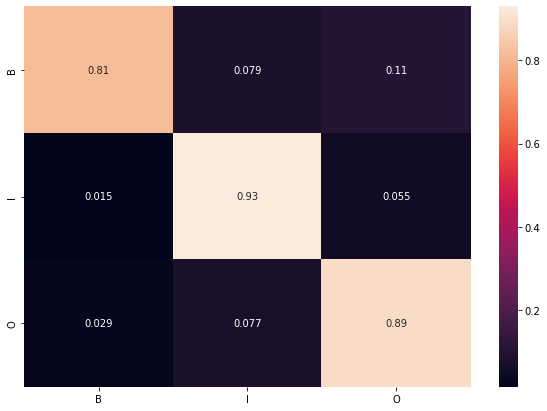

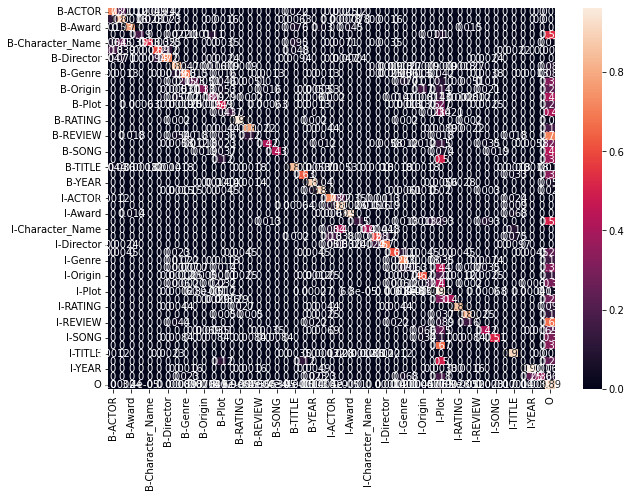

In [ ]:
def confusion_matrix(y_true, y_pred, summarize_iob_tags=False):
    f_y_test = list(chain.from_iterable(y_test))
    f_y_pred = list(chain.from_iterable(y_pred))
    if summarize_iob_tags:
        # summarize IOB tags to only keep the first letter (eg. B-art -> B)
        f_y_test = [t[0] for t in f_y_test]
        f_y_pred = [t[0] for t in f_y_pred]

    labels = np.unique(f_y_test)
    print(sklearn.metrics.classification_report(f_y_test, f_y_pred))
    print(f"Accuracy: {sklearn.metrics.accuracy_score(f_y_test, f_y_pred)} for {labels}")

    cm = sklearn.metrics.confusion_matrix(f_y_test, f_y_pred, labels=labels)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index = labels, columns = labels).fillna(0)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)

y_pred = crf.predict(X_test)

confusion_matrix(y_test, y_pred, summarize_iob_tags=True)
confusion_matrix(y_test, y_pred, summarize_iob_tags=False)

In [ ]:
y_pred = crf.predict(X_test)

print("--- performance of the CRF model")
print(metrics.flat_classification_report(y_test, y_pred))

### What did the CRF Learn

In [ ]:
# dependencies between words
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))
        
print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
B-DIRECTOR -> I-DIRECTOR 8.144652
B-Relationship -> I-Relationship 7.934025
B-Director -> I-Director 7.657286
B-Soundtrack -> I-Soundtrack 7.633903
B-CHARACTER -> I-CHARACTER 7.626753
B-Origin -> I-Origin 7.541464
B-RATINGS_AVERAGE -> I-RATINGS_AVERAGE 7.486595
I-Relationship -> I-Relationship 7.415971
B-Quote -> I-Quote 7.252637
B-SONG -> I-SONG  7.152583
B-REVIEW -> I-REVIEW 7.039991
B-PLOT -> I-PLOT  7.019813
I-Soundtrack -> I-Soundtrack 6.784711
I-SONG -> I-SONG  6.608520
I-PLOT -> I-PLOT  6.508591
B-Plot -> I-Plot  6.507602
I-Plot -> I-Plot  6.491733
B-GENRE -> I-GENRE 6.351696
I-Quote -> I-Quote 6.350370
I-Origin -> I-Origin 6.337123

Top unlikely transitions:
B-Genre -> B-GENRE -1.352769
O      -> I-DIRECTOR -1.500222
O      -> I-GENRE -1.509071
O      -> I-ACTOR -1.533482
O      -> I-TITLE -1.535453
O      -> I-RATINGS_AVERAGE -1.555913
O      -> I-CHARACTER -1.663362
B-Year -> B-GENRE -1.813201
O      -> I-YEAR  -1.888615
O      -> I-SONG  -1.896609
I-P

In [ ]:
# how CRF considers given features of words
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%-6s -> %-7s %0.6f" % (attr, label, weight))
        
print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
BOS    -> O       7.966930
-1:word.lower():song -> B-SONG  6.341372
word[-2:]:0s -> B-YEAR  5.714538
word.lower():watchable -> B-RATINGS_AVERAGE 5.553253
word.lower():unrated -> B-RATING 5.461143
-1:word.lower():line -> B-Quote 4.881312
BOS    -> B-Plot  4.831011
-1:word.lower():song -> B-Soundtrack 4.660715
word.lower():trailer -> B-TRAILER 4.430501
word.isdigit() -> B-Year  4.344114
word.lower():animated -> B-Genre 4.311472
word.istitle() -> B-TITLE 3.925878
word.lower():directed -> B-DIRECTOR 3.896898
word.lower():movies -> O       3.829352
-1:word.lower():academy -> I-Award 3.809395
word.lower():decent -> B-RATINGS_AVERAGE 3.654483
+1:word.lower():direct -> I-DIRECTOR 3.555862
word.lower():thriller -> B-GENRE 3.551039
word.lower():mediocre -> B-RATINGS_AVERAGE 3.447376
-1:word.lower():character -> B-CHARACTER 3.430935
word.lower():disney -> B-Director 3.318686
-1:word.lower():best -> I-Award 3.245934
-1:word.lower():viewers -> I-RATINGS_AVERAGE 3.244560
-1:word.lower(

### ELI5

In [ ]:
!pip install eli5
import eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 4.6 MB/s 
     |████████████████████████████████| 133 kB 45.6 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=fc97db5f95ecf60bcfc397cf5880bd717371fa5e9696e433e49195a900af56e0
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.


In [ ]:
# inspect model weights
eli5.show_weights(crf, top=10)  # top: number of features to show

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


From \ To,O,B-ACTOR,I-ACTOR,B-Actor,I-Actor,B-Award,I-Award,B-CHARACTER,I-CHARACTER,B-Character_Name,I-Character_Name,B-DIRECTOR,I-DIRECTOR,B-Director,I-Director,B-GENRE,I-GENRE,B-Genre,I-Genre,B-Opinion,I-Opinion,B-Origin,I-Origin,B-PLOT,I-PLOT,B-Plot,I-Plot,B-Quote,I-Quote,B-RATING,I-RATING,B-RATINGS_AVERAGE,I-RATINGS_AVERAGE,B-REVIEW,I-REVIEW,B-Relationship,I-Relationship,B-SONG,I-SONG,B-Soundtrack,I-Soundtrack,B-TITLE,I-TITLE,B-TRAILER,I-TRAILER,B-YEAR,I-YEAR,B-Year,I-Year
O,2.137,1.405,-1.533,0.439,-2.851,0.0,-1.152,1.273,-1.663,-0.009,-1.195,1.019,-1.5,0.33,-0.94,0.962,-1.509,1.166,-2.673,0.596,-3.002,0.45,-2.882,0.909,-3.132,1.326,-5.251,0.186,-3.135,0.799,-0.994,1.552,-1.556,1.136,-0.69,0.285,-2.308,0.707,-1.897,0.009,-2.185,1.046,-1.535,0.151,0.0,1.11,-1.889,0.67,-0.891
B-ACTOR,-0.016,0.0,6.22,0.0,-0.788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I-ACTOR,0.544,0.0,4.507,0.0,-1.203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.507,0.0,-0.222,0.0,0.0,0.0,0.0,0.0,1.865,0.0,-1.186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B-Actor,0.0,0.0,0.0,0.0,6.137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I-Actor,1.082,0.0,0.0,0.0,4.051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.092,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.086,-0.121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B-Award,0.0,0.0,0.0,0.0,0.0,0.0,5.938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I-Award,0.212,0.0,0.0,0.0,0.0,0.0,6.032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B-CHARACTER,-0.043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I-CHARACTER,0.169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B-Character_Name,-0.043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# check specific subset of features
eli5.show_weights(crf, top=10, targets=['O', 'B-DIRECTOR', 'I-DIRECTOR'])

In [ ]:
eli5.show_weights(crf, top=10, feature_re='^word',
                  horizontal_layout=False, show=['targets'])

### Save and load the trained model to pickle

In [ ]:
import pickle

In [ ]:
# save:
with open('mycrf.pickle', 'wb') as f:
    pickle.dump(crf, f)

In [ ]:
# load:
with open('mycrf.pickle', 'rb') as f:
    crf = pickle.load(f)

## Evaluation of CRF

In [131]:
! pip install nltk==3.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 7.7 MB/s 
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434692 sha256=153cc3f89f2abfb0ae36e570506095581ab101c34e8fb6ffd2bc94d075be7c07
  Stored in directory: /root/.cache/pip/wheels/45/6c/46/a1865e7ba706b3817f5d1b2ff7ce8996aabdd0d03d47ba0266
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7


In [132]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [229]:
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
query = "Who is the director of Good Will Hunting?"
query1 = "Given that I like The Lion King, Pocahontas, and The Beauty and the Beast, can you recommend some movies?"
query2 = "Can you tell me the publication date of Tom Meets Zizou?"
query4 = "Who is the director of Batman 1989?"
query5 = "show me movies that leonardo di caprio starred in."
tokens = word_tokenize(query6)
#for t in tokens:
#  if not(t.isalnum() or t.isdigit()):
#    tokens.remove(t)
tagged_tokens = pos_tag(tokens)
q = sent2features(tagged_tokens)
X = []
X.append(q)
tagged_tokens

[('can', 'MD'),
 ('you', 'PRP'),
 ('recommend', 'VB'),
 ('me', 'PRP'),
 ('a', 'DT'),
 ('movie', 'NN'),
 ('where', 'WRB'),
 ('barack', 'NN'),
 ('obama', 'NN'),
 ('starred', 'VBD'),
 ('in', 'IN')]

In [224]:
query4 = "Who is the director of Top Gun Maverick?"
query6 = 'can you recommend me a movie where barack obama starred in'

In [230]:
from numpy.ma.extras import vstack
y_pred = crf.predict(X)
pred = []
for i, t in enumerate(tokens):
  pred.append((t, y_pred[0][i]))

In [231]:
pd.DataFrame([[w for w,t in pred], [t for w,t in pred]], ['word', 'tag'])

,0,1,2,3,4,5,6,7,8,9,10
word,can,you,recommend,me,a,movie,where,barack,obama,starred,in
tag,O,O,O,O,O,O,O,B-ACTOR,I-ACTOR,O,O


## Question Pattern

In [ ]:
# from prediction to entity
def pred2entity(pred):
   entities = {} 
   entity = ''
   label = ''
   for i, (w, t) in enumerate(pred):
      if t != 'O':
         if pred[i-1][1][2:] != t[2:]:
            if entity != '' and label != '':
               if label in entities:
                  entities[label].append(entity)
               else:
                  entities[label] = [entity]
               entity = ''
               label = ''
            entity = w
            label = t[2:].lower()
         else:
            entity = entity + ' ' + w
   if entity != '' and label != '':
      if label in entities:
         entities[label].append(entity)
      else:
         entities[label] = entity
   return entities

In [ ]:
ent = pred2entity(pred)
ent

{'title': 'Top Gun Maverick'}

In [ ]:
import re

# a naive way for matching entities and relations
entity = ent[0]
print(entity)

question_pattern = "Who is the (.*) of ENTITY"

print("question pattern: {}\n".format(question_pattern))

question = re.sub(entity, "ENTITY", query4.rstrip("?"))  # preprocess the question

relation = re.match(question_pattern, question).group(1)  # match the relation using a pattern

print("recognized relation: {}\n".format(relation))

Batman 1989
question pattern: Who is the (.*) of ENTITY

recognized relation: director



In [ ]:
# clean sentence from entities to find relation
import re
sentence = re.sub(entity, "", query4.rstrip("?"))
sentence

'Who is the director of '

## Naive Pattern matching in queries

In [ ]:
# match entities and relation from CRF predictions
entity, label = pred2entity(pred)
print(entity)

Batman 1989


In [ ]:
! pip install rdflib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 500 kB 6.8 MB/s 
     |████████████████████████████████| 41 kB 610 kB/s 


In [ ]:
os.chdir('data')

In [ ]:
# define some prefixes
WD = rdflib.Namespace('http://www.wikidata.org/entity/')
WDT = rdflib.Namespace('http://www.wikidata.org/prop/direct/')
DDIS = rdflib.Namespace('http://ddis.ch/atai/')
RDFS = rdflib.namespace.RDFS
SCHEMA = rdflib.Namespace('http://schema.org/')

In [ ]:
# import knowledge graph
import rdflib
g = rdflib.Graph()
g.parse('./ddis-movie-graph.nt', format='turtle')

<Graph identifier=N9fe496b069554a239e22aebdd0ef667a (<class 'rdflib.graph.Graph'>)>

## More sophisticated Entity Linker

In [ ]:
!ls

autoencoder.h5	       ddis-movie-graph.tsv  KG.pickle		     wikidata
ddis-graph-embeddings  entities		     MIT_corpus
ddis-movie-graph.nt    entity_embeds_2d.npy  relation_embeds_2d.npy


In [ ]:
os.chdir('..')
os.chdir('data')

FileNotFoundError: [Errno 2] No such file or directory: 'data'

In [ ]:
# load knowledge graph from pickle
import pickle
with open('KG.pickle', 'rb') as f:
    graph = pickle.load(f)

In [ ]:
!ls

assignment.html       entity_embeds.npy       relation_embeds.npy
assignment.ipynb      entity_ids.del	      relation_ids.del
autoencoder.pth       README.md
entity_embeds_2d.npy  relation_embeds_2d.npy


In [ ]:
from rdflib import URIRef

entity_type_map = {
    'TITLE': [WD.Q11424, WD.Q24856, WD.Q5398426, WD.Q7725310, WD.Q15416],
    'DIRECTOR': [WD.Q2526255, WD.Q3455803],
    'CHARACTER': [WD.Q95074, WD.Q15773347, WD.Q15632617],
    'ACTOR': [WD.Q33999, WD.Q10800557],
    'GENRE': [WD.Q483394]
}

entity_predicate_map = {
    'DIRECTOR': [WDT.P57],
    'CHARACTER': [WDT.P1441, WDT.P674],
    'ACTOR': [WDT.P161, WDT.P175],
    'GENRE': [WDT.P136]
}


def get_entities(graph):
    nodes = []
    for node in graph.all_nodes():
        if isinstance(node, URIRef) and graph.value(node, RDFS.label):
            nodes.append((node.toPython()[len(WD):], graph.value(node, RDFS.label)))
    df = pd.DataFrame(nodes, columns=['Entity', 'EntityLabel'])
    df = df.drop_duplicates().reset_index(drop=True)
    return df

df = get_entities(graph)
df.to_csv("entities/graph_entities.csv", index=False)


def get_movies(graph):
    entities = []
    nodes = [s for s in graph.subjects(WDT.P57, None) if graph.value(s, RDFS.label)]

    for s in nodes:
        entities.append((s.toPython()[len(WD):], graph.value(s, RDFS.label)))

    df = pd.DataFrame(entities, columns=['Entity', 'EntityLabel'])
    df = df.drop_duplicates().reset_index(drop=True)
    return df

df = get_movies(graph)
df.to_csv("entities/graph_movies.csv", index=False)


def get_actors(graph):
    entities = []
    nodes = [s for s in graph.objects(None, WDT.P161) if graph.value(s, RDFS.label)]

    for s in nodes:
        entities.append((s.toPython()[len(WD):], graph.value(s, RDFS.label)))

    df = pd.DataFrame(entities, columns=['Entity', 'EntityLabel'])
    df = df.drop_duplicates().reset_index(drop=True)
    return df

df = get_actors(graph)
df.to_csv("entities/graph_actors.csv", index=False)


def get_directors(graph):
    entities = []
    nodes = [s for s in graph.objects(None, WDT.P57) if graph.value(s, RDFS.label)]

    for s in nodes:
        entities.append((s.toPython()[len(WD):], graph.value(s, RDFS.label)))

    df = pd.DataFrame(entities, columns=['Entity', 'EntityLabel'])
    df = df.drop_duplicates().reset_index(drop=True)
    return df

df = get_directors(graph)
df.to_csv("entities/graph_directors.csv", index=False)


def get_characters(graph):
    entities = []
    nodes = [s for s in graph.subjects(WDT.P175, None) if graph.value(s, RDFS.label)]
    characters = [(s, p, o) for n in nodes for t in entity_type_map['CHARACTER'] for s, p, o in
                  graph.triples((n, WDT.P31, t))]

    for s, p, o in characters:
        entities.append((s.toPython()[len(WD):], graph.value(s, RDFS.label)))

    df = pd.DataFrame(entities, columns=['Entity', 'EntityLabel'])
    df = df.drop_duplicates().reset_index(drop=True)
    return df

df = get_characters(graph)
df.to_csv("entities/graph_characters.csv", index=False)


def get_genres(graph):
    entities = []
    nodes = [s for s in graph.objects(None, WDT.P136) if graph.value(s, RDFS.label)]

    for s in nodes:
        entities.append((s.toPython()[len(WD):], graph.value(s, RDFS.label)))

    df = pd.DataFrame(entities, columns=['Entity', 'EntityLabel'])
    df = df.drop_duplicates().reset_index(drop=True)
    return df

df = get_genres(graph)
df.to_csv("entities/graph_genres.csv", index=False)

In [ ]:
# load the embeddings
os.chdir('./ddis-graph-embeddings')
entity_emb = np.load('./entity_embeds.npy')
relation_emb = np.load('./relation_embeds.npy')
entity_file = './entity_ids.del'
relation_file = './relation_ids.del'

In [ ]:
# load the dictionaries
import rdflib
import csv
with open(entity_file, 'r') as ifile:
    ent2id = {rdflib.term.URIRef(ent): int(idx) for idx, ent in csv.reader(ifile, delimiter='\t')}
    id2ent = {v: k for k, v in ent2id.items()}
with open(relation_file, 'r') as ifile:
    rel2id = {rdflib.term.URIRef(rel): int(idx) for idx, rel in csv.reader(ifile, delimiter='\t')}
    id2rel = {v: k for k, v in rel2id.items()}

In [ ]:
# define some prefixes
import rdflib
WD = rdflib.Namespace('http://www.wikidata.org/entity/')
WDT = rdflib.Namespace('http://www.wikidata.org/prop/direct/')
DDIS = rdflib.Namespace('http://ddis.ch/atai/')
RDFS = rdflib.namespace.RDFS
SCHEMA = rdflib.Namespace('http://schema.org/')

In [ ]:
# link the entity by finding its corresponding node in the knowledge graph
ent2lbl = {ent: str(lbl) for ent, lbl in graph.subject_objects(RDFS.label)}
lbl2ent = {lbl: ent for ent, lbl in ent2lbl.items()}
rel2lbl = {rel: str(lbl) for rel, lbl in graph.subject_objects(RDFS.label)}

In [ ]:
entity = 'Top Gun Maverick'
relation = 'director'

In [ ]:
import editdistance

tmp = 9999
match_node = ""
print("--- entity matching for \"{}\"\n".format(entity))
for key, value in ent2lbl.items():
    if editdistance.eval(value, entity) < tmp:
        tmp = editdistance.eval(value, entity)
        match_node = key

tmp = 9999
match_pred = ""
print("\n--- relation matching for \"{}\"\n".format(relation))
for key, value in rel2lbl.items():
    if editdistance.eval(value, relation) < tmp:
        tmp = editdistance.eval(value, relation)
        match_pred = key

print("\n--- the matching node of \"{}\" is {}\n".format(entity, match_node))
print("--- the matching predicates of \"{}\" is {}\n".format(relation, match_pred))

--- entity matching for "Top Gun Maverick"


--- relation matching for "director"


--- the matching node of "Top Gun Maverick" is http://www.wikidata.org/entity/Q31202708

--- the matching predicates of "director" is http://www.wikidata.org/prop/direct/P57



In [ ]:
query_template = "SELECT DISTINCT ?x ?y WHERE {{ <{}> <{}> ?x . }}".format(match_node, match_pred)

print("--- sparql query: {}".format(query_template))

qres = graph.query(query_template)

print("\n--- querying results: ")
for row in qres:
    print(ent2lbl[row.x])
    answer = ent2lbl[row.x]

--- sparql query: SELECT DISTINCT ?x ?y WHERE { <http://www.wikidata.org/entity/Q31202708> <http://www.wikidata.org/prop/direct/P57> ?x . }

--- querying results: 
Joseph Kosinski


In [ ]:
answer_template = "Hi, the {} of {} is {}".format(relation, entity, answer)

print("\n--- generated response: {}.".format(answer_template))


--- generated response: Hi, the director of Top Gun Maverick is Joseph Kosinski.


## Sentence Transformer

In [ ]:
! pip install -U sentence-transformers

### Data Cleaning

In [ ]:
predicates = {p for p in graph.predicates()}
list(predicates)

[rdflib.term.URIRef('http://www.wikidata.org/prop/direct/P3402'),
 rdflib.term.URIRef('http://www.wikidata.org/prop/direct/P1365'),
 rdflib.term.URIRef('http://www.wikidata.org/prop/direct/P3300'),
 rdflib.term.URIRef('http://www.wikidata.org/prop/direct/P1346'),
 rdflib.term.URIRef('http://www.wikidata.org/prop/direct/P3156'),
 rdflib.term.URIRef('http://www.wikidata.org/prop/direct/P1142'),
 rdflib.term.URIRef('http://www.wikidata.org/prop/direct/P1050'),
 rdflib.term.URIRef('http://www.wikidata.org/prop/direct/P275'),
 rdflib.term.URIRef('http://www.wikidata.org/prop/direct/P1001'),
 rdflib.term.URIRef('http://www.wikidata.org/prop/direct/P25'),
 rdflib.term.URIRef('http://www.wikidata.org/prop/direct/P5021'),
 rdflib.term.URIRef('http://www.wikidata.org/prop/direct/P361'),
 rdflib.term.URIRef('http://www.wikidata.org/prop/direct/P1429'),
 rdflib.term.URIRef('http://www.wikidata.org/prop/direct/P551'),
 rdflib.term.URIRef('http://www.wikidata.org/prop/direct/P112'),
 rdflib.term.URI

In [ ]:
properties = list(predicates)

In [ ]:
len(properties)

255

In [ ]:
prop = []
for p in properties:
    try:
        prop.append(rel2lbl[p]) 
    except:
        continue

In [ ]:
len(prop)

253

In [ ]:
prop[:10]

['CNC film rating (Romania)',
 'replaces',
 'musical conductor',
 'winner',
 'Australian Classification',
 'political ideology',
 'medical condition',
 'copyright license',
 'applies to jurisdiction',
 'mother']

In [ ]:
# prop to csv
import csv
with open('properties.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(prop)

In [ ]:
dirname = os.path.dirname('__file__')

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
property_emb = model.encode(prop)
np.save(os.path.join(dirname, '../../data/wikidata/property_embeds.npy'), property_emb)

In [ ]:
# load graph_properties_expanded
properties_exp = pd.read_csv(os.path.join(dirname, '../../data/wikidata/graph_properties_expanded.csv'))
property_labels = properties_exp['PropertyLabel']

In [ ]:
property_labels[:10]

0       film editor
1               NaN
2           IMDb ID
3               NaN
4       cast member
5               NaN
6    place of birth
7               NaN
8         performer
9               NaN
Name: PropertyLabel, dtype: object

### Find relations from embeddings

In [ ]:
sentence = 'who is the director of'

In [ ]:
from sentence_transformers import SentenceTransformer
sentences = [sentence]

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(sentences)

In [ ]:
# compare embeddings to relations in the knowledge graph
import numpy as np
from sklearn.metrics import pairwise_distances

# compute the cosine similarity between the embeddings and the relation embeddings
dist = pairwise_distances(embeddings.reshape(1, -1), property_emb).reshape(-1)
most_likely = dist.argsort()
top_match = [
    (
        properties_exp.loc[properties_exp['PropertyLabel'] == prop[index], 'Property'].values[0],
        prop[index],  # label
        dist[index],  # score
        rank + 1,  # rank
    )
    for rank, index in enumerate(most_likely[:3])]
print(top_match)

[('http://www.wikidata.org/prop/direct/P57', 'director', 0.73943156, 1), ('http://www.wikidata.org/prop/direct/P3174', 'art director', 0.78754467, 2), ('http://www.wikidata.org/prop/direct/P344', 'director of photography', 0.78950274, 3)]


## spaCy Entity Linker

In [ ]:
# use spacy entity linker to find the most similar entity in the graph
import spacy
nlp = spacy.load('en_core_web_sm')
doc = nlp(ent[0])
entity_linker = nlp.get_pipe('entity_linker')
doc = entity_linker(doc)
topn_ent = doc._.kb_ents[0][0]
topn_ent

# BERT

## BERT base cased

In [ ]:
! pip install simpletransformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 250 kB 39.0 MB/s 
     |████████████████████████████████| 9.2 MB 39.6 MB/s 
     |████████████████████████████████| 441 kB 54.6 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 1.3 MB 46.4 MB/s 
     |████████████████████████████████| 7.6 MB 53.7 MB/s 
     |████████████████████████████████| 1.9 MB 57.0 MB/s 
     |████████████████████████████████| 5.3 MB 56.7 MB/s 
     |████████████████████████████████| 163 kB 73.5 MB/s 
     |████████████████████████████████| 182 kB 71.6 MB/s 
     |████████████████████████████████| 166 kB 66.3 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 166 kB 74.0 MB/s 
     |████████████████████████████████| 162 kB 65.3 MB/s 
     |████████████████████████████████| 162 kB 75.1 MB/s 
     |█████████████████████████████

In [ ]:
from simpletransformers.ner import NERModel , NERArgs

In [ ]:
# model parameters
model_args = NERArgs()
model_args.num_train_epochs = 2
model_args.learning_rate = 1e-4
model_args.overwrite_output_dir =True
model_args.train_batch_size = 32
model_args.eval_batch_size = 8
model_args.evaluate_during_training = True
model_args.evaluate_during_training_steps = 1000
model_args.evaluate_during_training_verbose = True

In [ ]:
MIT_train_df.rename(columns = {'tags':'labels'}, inplace = True)
MIT_test_df.rename(columns = {'tags':'labels'}, inplace = True)

In [ ]:
tags = MIT_train_df["labels"].unique().tolist()
tags

['O',
 'B-ACTOR',
 'I-ACTOR',
 'B-YEAR',
 'B-TITLE',
 'B-GENRE',
 'I-GENRE',
 'B-DIRECTOR',
 'I-DIRECTOR',
 'B-SONG',
 'I-SONG',
 'B-PLOT',
 'I-PLOT',
 'B-REVIEW',
 'B-CHARACTER',
 'I-CHARACTER',
 'B-RATING',
 'B-RATINGS_AVERAGE',
 'I-RATINGS_AVERAGE',
 'I-TITLE',
 'I-RATING',
 'B-TRAILER',
 'I-TRAILER',
 'I-REVIEW',
 'I-YEAR',
 'B-Actor',
 'I-Actor',
 'B-Plot',
 'I-Plot',
 'B-Opinion',
 'I-Opinion',
 'B-Award',
 'I-Award',
 'B-Year',
 'B-Genre',
 'B-Origin',
 'I-Origin',
 'B-Director',
 'I-Director',
 'I-Genre',
 'I-Year',
 'B-Soundtrack',
 'I-Soundtrack',
 'B-Relationship',
 'I-Relationship',
 'B-Character_Name',
 'I-Character_Name',
 'B-Quote',
 'I-Quote']

In [ ]:
model_bert = NERModel('bert', 'bert-base-cased', labels=tags, args = model_args)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [ ]:
model_bert.train_model(MIT_train_df,eval_data = MIT_test_df)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/550 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/550 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/550 [00:00<?, ?it/s]

(1100,
 defaultdict(list,
             {'global_step': [550, 1000, 1100],
              'train_loss': [0.4348756968975067,
               0.20596444606781006,
               0.11719483882188797],
              'eval_loss': [0.28622337306891993,
               0.2571320760344282,
               0.2538074655513364],
              'precision': [0.7563383817253786,
               0.7961182024829516,
               0.7971660981369719],
              'recall': [0.8198639455782313,
               0.8259410430839003,
               0.8266666666666667],
              'f1_score': [0.7868210306406686,
               0.8107554645416908,
               0.8116484103660165]}))

In [ ]:
result_bert, model_outputs, preds_list = model_bert.eval_model(MIT_test_df)

  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/550 [00:00<?, ?it/s]

In [ ]:
result_bert

{'eval_loss': 0.2538074655513364,
 'precision': 0.7971660981369719,
 'recall': 0.8266666666666667,
 'f1_score': 0.8116484103660165}

In [ ]:
prediction, model_output = model_bert.predict(["Who is the director of Good Will Hunting?"])

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
prediction

[[{'Who': 'O'},
  {'is': 'O'},
  {'the': 'O'},
  {'director': 'O'},
  {'of': 'O'},
  {'Good': 'B-TITLE'},
  {'Will': 'I-TITLE'},
  {'Hunting?': 'I-TITLE'}]]

## DISTILBERT

In [ ]:
model_distilbert = NERModel('distilbert', 'distilbert-base-cased', labels=tags, args = model_args)

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForTokenClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this 

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

In [ ]:
model_distilbert.train_model(MIT_train_df, eval_data=MIT_test_df)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/550 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/550 [00:00<?, ?it/s]

(1100,
 defaultdict(list,
             {'global_step': [550, 1000, 1100],
              'train_loss': [0.4161023795604706,
               0.22040718793869019,
               0.19360893964767456],
              'eval_loss': [0.28258357464843853,
               0.26198103998999367,
               0.26301284176890144],
              'precision': [0.7756438622886981,
               0.7902516276614464,
               0.792262479164839],
              'recall': [0.7949206349206349,
               0.8146938775510204,
               0.8191383219954649],
              'f1_score': [0.7851639491130622,
               0.8022866330221965,
               0.8054762754191936]}))

In [ ]:
result_distilbert, model_outputs, preds_list = model_distilbert.eval_model(MIT_test_df)

  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/550 [00:00<?, ?it/s]

In [ ]:
result_distilbert

{'eval_loss': 0.26301284176890144,
 'precision': 0.792262479164839,
 'recall': 0.8191383219954649,
 'f1_score': 0.8054762754191936}

In [ ]:
prediction, model_output = model_distilbert.predict(["Who is the director of Good Will Hunting?"])

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
prediction

[[{'Who': 'O'},
  {'is': 'O'},
  {'the': 'O'},
  {'director': 'O'},
  {'of': 'O'},
  {'Good': 'B-TITLE'},
  {'Will': 'I-TITLE'},
  {'Hunting?': 'I-TITLE'}]]